# Pipeline TE

In [1]:
import os
os.chdir('/home/clemens/armed_conflict_avalanche/')

from workspace.utils import *
from voronoi_globe.interface import load_voronoi
from arcolanche.pipeline import *
from arcolanche.transfer_entropy_func import *

import statsmodels.api as sm

from utils_CB import get_coarsegrained, plot_cells, get_ids_from_centroid

from math import factorial

from shapely.geometry import LineString
from keplergl import KeplerGl


# Data, subset

In [2]:
conflict_type = "battles"
mesoscale = (32,453,3) #(dt, dx, gridix)
coarse = (32, 80, 3)

dt, dx, gridix = mesoscale

#data
load_pickle(f"avalanches/{conflict_type}/gridix_{gridix}/te/conflict_ev_{str(dt)}_{str(dx)}.p")
count_ts = get_coarsegrained(conflict_type, scale = mesoscale, binary=True)
polygons = load_voronoi(dx, gridix) #dx=57/b=528km, gridix=3

Subset of dataset is used: Construct.py subsets neighborhood of degree three around central node 7311. Quite messy way to do it but yeah.

Cells in subset: 35
tuples in subset of size 3: 1190.0
dt: 32, dx: 453 gridix: 3


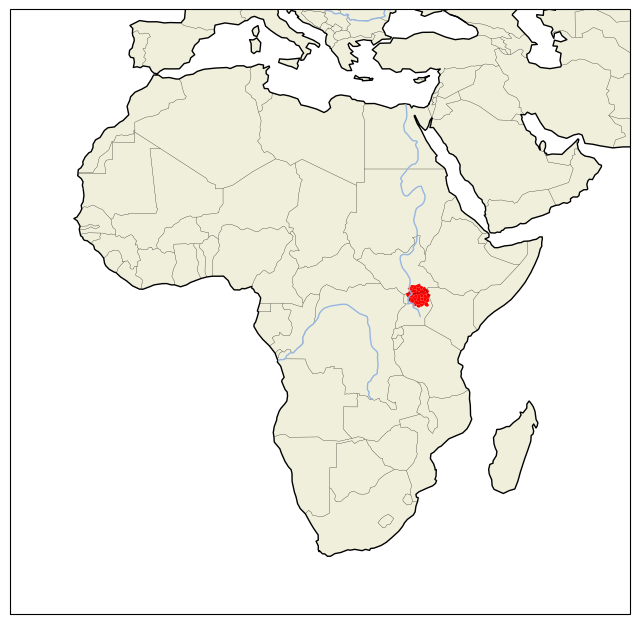

In [3]:
size = 3
degree = 2
centroid = 7311 #counts: 218 
cell_ids = get_ids_from_centroid(polygons, size= size, centroid = 7311)
print("Cells in subset:", len(cell_ids))


def binomial(n, k):
#number of unique k sets in n
    return (factorial(n)/(factorial(k)*factorial(n-k)))

print(f"tuples in subset of size {size}:", binomial(len(cell_ids), 2)*2)

#Plot subset (used in pipeline)
plot_cells(cell_ids, mesoscale, "battles", verbose=False)

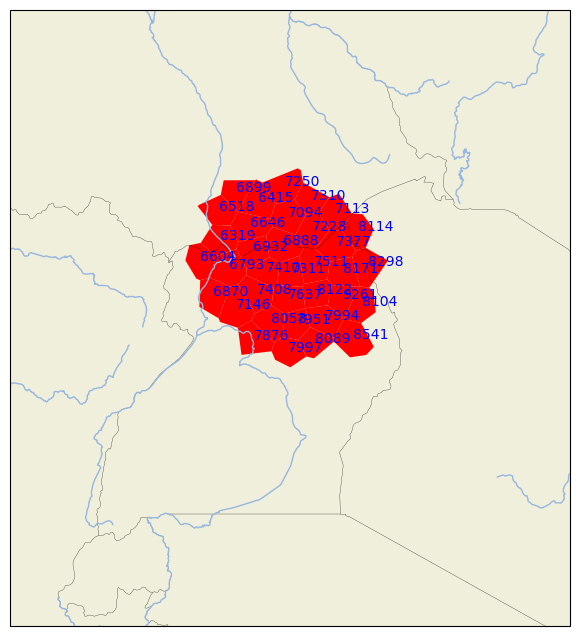

In [4]:
# Zoom in
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

# Specify polygon and event here
for i, x in enumerate(cell_ids):
    poly = polygons.loc[[x]]
    poly.plot(ax=ax, color="red")
    
    # Get the centroid of the polygon
    centroid = poly.geometry.centroid.iloc[0]
    # Place the index of the polygon as text on the map
    ax.text(centroid.x, centroid.y, str(x), color='blue', transform=ccrs.Geodetic())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.LAND)   
ax.add_feature(cfeature.RIVERS)

# Zoom in on Kenya, South Sudan, and Uganda

ax.set_extent([28, 38, -3, 8], crs=ccrs.PlateCarree())

plt.show()

# Avalanche construction/Get TE's

In [5]:
#create avalanche (only create causla graph -> setup avalanche is commented out)
ava_1 = Avalanche(dt = dt, dx = dx, gridix=3, degree=degree, size = size, setup=True)
#get (tuple), TEs
self_edges = ava_1.self_edges
pair_edges = ava_1.pair_edges

print(ava_1.causal_graph) #esged: only significant MI/TE

/home/clemens/miniconda3/envs/conflict/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CausalGraph with 35 nodes and 155 edges


In [31]:
def calculate_significant_edges(self_edges, pair_edges, summary = False):
        
    significant_edges = [[] for _ in range(degree+1)]
    counts = np.zeros(degree+1)
    
    #self edges
    for poly, (te, te_shuffle) in self_edges.items():
        if (te > te_shuffle).mean() >= (95 / 100):
            significant_edges[0].append([(poly, poly), te])
    counts[0] = len(self_edges)

    #pair edges
    for pair, (te, te_shuffle) in pair_edges.items():
        d = pair[2]
        if 1 <= d <= degree:
            counts[d] += 1
            if (te > te_shuffle).mean() >= (95/100): #threshold!
                significant_edges[d].append([(pair[0], pair[1]), te])            
    
    #ratio dataframe 
    if summary:
        df = pd.DataFrame(
            {
                "Degree": np.arange(degree+1),
                "Total edges": counts,
                "Significant edges": [len(edges) for edges in significant_edges],
            }
        )
        df["Ratio"] = round(df["Significant edges"] / df["Total edges"], 3)
        
        return df, significant_edges
    
    else:
        return significant_edges

(   Degree  Total edges  Significant edges  Ratio
 0       0         35.0                 23  0.657
 1       1        170.0                 61  0.359
 2       2        278.0                 71  0.255,
 [[[(6319, 6319), 0.04277996698884525],
   [(6415, 6415), 0.06367909563456556],
   [(6518, 6518), 0.04642516605476375],
   [(6646, 6646), 0.03663223979425012],
   [(6793, 6793), 0.03473682288556241],
   [(6888, 6888), 0.021934608760627278],
   [(7094, 7094), 0.03334751333128681],
   [(7113, 7113), 0.05328832469258493],
   [(7146, 7146), 0.14437077104245935],
   [(7311, 7311), 0.19518097721420694],
   [(7408, 7408), 0.27685227769672394],
   [(7410, 7410), 0.10057639832126701],
   [(7511, 7511), 0.02405852873170396],
   [(7637, 7637), 0.35047774008145305],
   [(7876, 7876), 0.009000076930982563],
   [(7951, 7951), 0.0902452994290715],
   [(7994, 7994), 0.06943858536029401],
   [(7997, 7997), 0.01907998782589067],
   [(8058, 8058), 0.07294396768750934],
   [(8089, 8089), 0.03334751333128681]

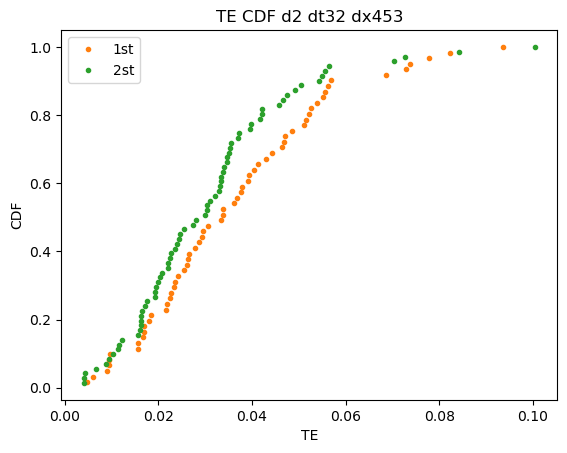

In [37]:
def plot_save_ecdf(significant_edges):
    #get TEs
    for d in range(1, degree+1):
        sig = significant_edges[d]
        tes = [te for tuples, te in sig]
        
        # Compute ECDFs using statsmodels
        ecdf = sm.distributions.ECDF(tes)
        x = np.sort(tes)
        y = ecdf(x)
        plt.plot(x, y, 'o', label=f"{d}st", color="C"+str(d), markersize=3)
    
    
    # Add labels and title
    plt.ylabel("CDF")
    plt.xlabel("TE")
    plt.title(f"TE CDF d{degree} dt{dt} dx{dx}")

    # Add legend
    plt.legend()
    


plot_save_ecdf(significant_edges)

In [30]:
def save_map(t, s, polygons, significant_edges): 
    map_ = KeplerGl()
    
    for d in range(1, degree+1):
        sig = significant_edges[d]
        edges = [(pair[0], pair[1]) for pair, te in sig]
        edges_df = pd.DataFrame(edges, columns=["source", "target"])
        lines = []

        for index, row in edges_df.iterrows():
            source_polygon = polygons[polygons.index == row['source']].geometry.values[0]
            target_polygon = polygons[polygons.index == row['target']].geometry.values[0]

            # Create a line between centroids of source and target polygons
            line = LineString([source_polygon.centroid, target_polygon.centroid])
            lines.append({
                'type': 'Feature',
                'geometry': line.__geo_interface__,
                'properties': {
                    'source_id': int(row['source']),  # Ensure integer conversion
                    'target_id': int(row['target'])   # Ensure integer conversion
                }
            })

        lines_geojson = {'type': 'FeatureCollection', 'features': lines}
        lines_geojson = json.dumps(lines_geojson)
        map_.add_data(data=json.loads(lines_geojson), name=f'{d}st degree')
    
    polygons_geojson = polygons.to_json()
    map_.add_data(data=json.loads(polygons_geojson), name=f'Polygons, dx={s}')
    
    # Save the map as HTML or display it
    map_.save_to_html(file_name=f'Results/kepler/kepler_d{degree}_dt{t}_dx{s}.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to Results/kepler/kepler_d2_dt2_dx453.html!
